In [38]:
import sys
sys.path.append('..')
sys.path.append('../..')
from data.utils.patch_embedding_dataloader import PatchEmbeddingDataloader
from torchvision import io
from encoders.openclip_encoder import OpenCLIPNetworkConfig, PatchDropout, PatchDropoutFov
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.colormaps import apply_colormap

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Hyper Parameters

In [5]:
device = "cuda:4"
"""The device to run on"""
patch_tile_size_range = (0.08, 0.5)
"""The range of tile sizes to sample from for patch-based training"""
patch_tile_size_res: int = 2
"""The number of tile sizes to sample from for patch-based training"""
patch_stride_scaler: float = .5
"""The stride scaler for patch-based training"""
network = OpenCLIPNetworkConfig(
    device=device, clip_n_dims=1024, clip_model_type="ViT-H-14", clip_model_pretrained='laion2b_s32b_b79k'
    )
network.output_tokens = False


"""specifies the vision-language network config"""
clip_downscale_factor: int = 1
"""The downscale factor for the clip pyramid"""

patch_embedder = PatchEmbeddingDataloader(
    device=device,
    cfg={
        'tile_ratio': 0.08,
        'stride_ratio': 0.85, 
        'image_shape': [1080, 1920]
      },
    model=network.setup(),
)
patch_embedder.create(None)
# clip_interpolator.embed_size = 512
image_encoder = patch_embedder.model
# image_encoder.model.visual.load_state_dict(
#     torch.load("/home/sandeepmukh/DeepUL294Proj/DUL294P/checkpoints/model.pth")
# )
image_encoder.model.visual.patch_dropout = PatchDropout(.75)

In [6]:
def get_median(probs, H, W, thresh=.4):
  grid = (probs[..., :1] > thresh).view(H, W).float()
  mid = grid.nonzero().median(dim = 0).values
  return [mid[1].item()], [mid[0].item()]

In [3]:
video = io.read_video('/home/sandeepmukh/DeepUL294Proj/DUL294P/data/IMG_5338.MOV')[0]

/home/sandeepmukh/DeepUL294Proj/.deepulenv/lib/python3.10/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


In [43]:
patch_embedder.set_fov_center(None)
probs_emp = torch.zeros(15*27, 2).half().to(device)
image_encoder.set_positives('a young man wearing red')
medians, all_probs, idxs = [], [], []
video_prep = video.permute(0, 3, 1, 2).float() / 255.

for frame in tqdm(video_prep):
  patch_embedder.clear()
  embds, idx = patch_embedder.add_images([frame])
  probs = image_encoder.get_relevancy(embds[0], 0)
  probs_emp *= .8
  probs_emp[idx] = probs
  median = get_median(probs_emp, 15, 27, probs.float().quantile(.8))
  medians.append(median)
  all_probs.append(probs_emp.clone().cpu())
  idxs.append(idx[0].clone().cpu())
  patch_embedder.set_fov_center(torch.tensor(median[::-1]).squeeze())


100%|██████████| 231/231 [00:51<00:00,  4.47it/s]


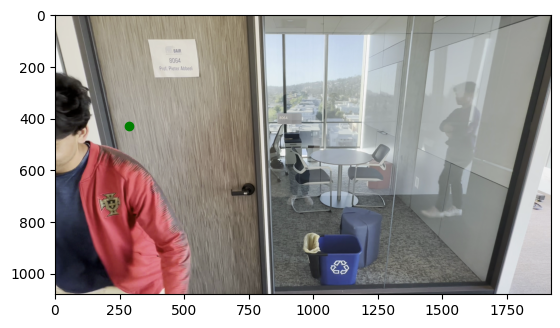

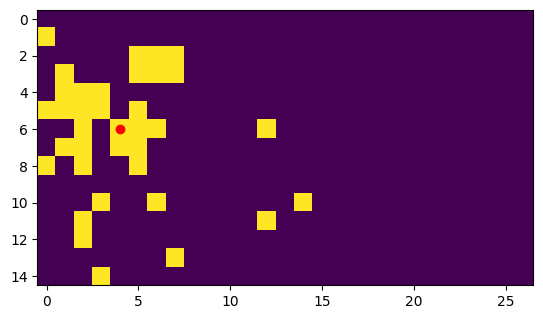

In [45]:
idx = 170
plt.imshow(video[idx])
plt.scatter((medians[idx][0][0] / 15)*1080, (medians[idx][1][0]/27)*1920, c='g')
plt.show()
plt.imshow((all_probs[idx][..., 0].reshape(15, 27).detach().cpu().numpy() > .55))
plt.scatter(*medians[idx], c='r')

In [14]:
patches = patchify(video[0].permute(2,0,1)[None], 86)
patches.shape[1:3]

torch.Size([14, 24])

In [30]:
from torch.nn import functional as F 

def patchify(imgs, patch_size):
    """
    imgs: (N, 3, H, W)
    x: (N, L, patch_size**2 *3)
    """
    p = patch_size
    kc, kh, kw = 3, p, p  # kernel size
    pad = (kw-(imgs.size(3)%kw // 2), kw-(imgs.size(3)%kw // 2),
                    kh-(imgs.size(2)%kh // 2), kh-(imgs.size(2)%kh // 2))
    imgs = F.pad(imgs, pad, mode='replicate')
    assert imgs.shape[2] % p == 0 and imgs.shape[3] % p == 0

    h = imgs.shape[2] // p
    w = imgs.shape[3] // p
    x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
    x = torch.einsum('nchpwq->nhwpqc', x)
    x = x.reshape(shape=(imgs.shape[0], h, w, p**2 * 3))
    return x

def unpatchify(x, patch_size):
    """
    x: (N, L, patch_size**2 *3)
    imgs: (N, 3, H, W)
    """
    p = patch_size
    # h = w = int(x.shape[1]**.5)
    # assert h * w == x.shape[1]
    h, w = x.shape[1], x.shape[2]
    x = x.reshape(shape=(x.shape[0], x.shape[1], x.shape[2], p, p, 3))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], 3, h * p, w * p))
    return imgs
  
from mpl_toolkits.axes_grid1 import ImageGrid
def plot_patches(tensor):
    h, w = tensor.shape[1:3]
    fig = plt.figure(figsize=(15, 15))
    grid = ImageGrid(fig, 111, nrows_ncols=(h, w), axes_pad=0.0)
    tensor = tensor.reshape(h*w, 86, 86, 3)

    for i, ax in enumerate(grid):
        patch = tensor[i].numpy() 
        ax.imshow(patch)
        ax.axis('off')

    return fig

def get_foveated_image(img, median):
    fov = PatchDropoutFov(.75, False)
    patches = patchify(img[None], 86)
    shape_orig = patches.shape
    blank = torch.zeros_like(patches)
    patches, keep = fov(patches.view(patches.shape[0], -1, 86*86*3), torch.tensor(median).squeeze(), 1, True, height=patches.shape[1])
    patches = patches.reshape(1, -1, 86, 86, 3)
    # patches[torch.rand(1, patches.shape[1], 86, 86) < .5, :] = 0
    patches = patches.reshape(1, -1, 86*86*3)
    blank = blank.reshape(1, -1, 86*86*3)
    blank[:, keep] = patches
    
    return blank.reshape(shape_orig)

# plot_patches(get_foveated_image(video[40].permute(2,0,1), medians[40][::-1]))
None

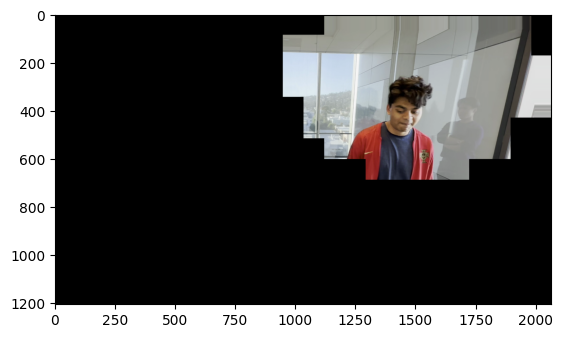

In [47]:
plt.imshow(
          unpatchify(
              get_foveated_image(video[40].permute(2, 0, 1), medians[40][::-1]), 86
          )
          .squeeze()
          .permute(1, 2, 0)
      )

100%|██████████| 231/231 [00:00<00:00, 767.91it/s]


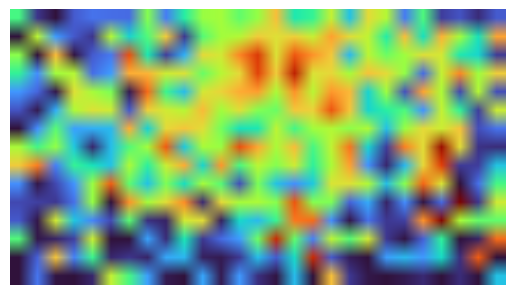

: 

In [48]:
# put images together as a video and plot the centers on each image

# imgs = torch.stack(imgs)
# centers = torch.tensor(centers)

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm

frames = []  # for storing the generated images
fig = plt.figure()
plt.axis("off")
for i in tqdm(range(len(video))):
    frames.append(
        [
            plt.imshow(
                # unpatchify(
                #     get_foveated_image(video[i].permute(2, 0, 1), medians[i][::-1]), 86
                # )
                # .squeeze()
                # .permute(1, 2, 0)
                apply_colormap(all_probs[i][..., :1]).reshape(15, 27, 3).detach().cpu().numpy(),
                interpolation='bilinear'
            )
        ]
    )

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True, repeat_delay=1000)
writergif = animation.PillowWriter(fps=20)
ani.save("movie_clip_map_1.gif", writer=writergif)
plt.show()